In [10]:
# Import libraries and data
import os
import numpy as np
import pickle

from src.utils.linear_regressor import perform_linear_regression
from config.settings import saved_models_path
from src.utils.column_import import columns_dif

s_x , s_y , v_x , v_y , a_x , a_y, a_x_a, a_y_a, a_x_b, a_y_b = columns_dif






# Relative Model (2 cars)


Acceleration model with 4 parameters
\begin{align}
a(k-1) &= - \overline c_1 a(k)  + \overline c_2 \bigl( v(k+1) - v(k) \bigr) \\
a(k-1) &= - \overline c_3 a(k)  + \overline c_4 \bigl( s(k+1) - s(k) - dt \  v(k)\bigr)
\end{align}

Model in matrix notation
\begin{align}
    \begin{bmatrix}
        a(k-1) \\ a(k-1)       
    \end{bmatrix}
    =
    \begin{bmatrix}
         -a(k)  & v(k+1) - v(k)  & 0 & 0 \\
         0 & 0 & -a(k) &    s(k+1) - s(k) - dt \  v(k)
        \end{bmatrix}
        \begin{bmatrix}
        \overline c_1 \\
        \overline c_2 \\
        \overline c_3 \\
        \overline c_4 \\
    \end{bmatrix}
\end{align}

Add x and y components

\begin{align}
    \begin{bmatrix}
        a_x(k-1) \\ 
        a_x(k-1) \\ 
        a_y(k-1) \\ 
        a_y(k-1)       
    \end{bmatrix}
    =
    \begin{bmatrix}
        -a_x(k)  & v_x(k+1) - v_x(k)  & 0 & 0                   \\ 
        0 & 0 & -a_x(k) &    s_x(k+1) - s_x(k) - dt \  v_x(k)   \\ 
        -a_y(k)  & v_y(k+1) - v_y(k)  & 0 & 0                   \\
        0 & 0 & -a_y(k) &    s_y(k+1) - s_y(k) - dt \  v_y(k)
    \end{bmatrix}
    \begin{bmatrix}
        \overline c_1 \\
        \overline c_2 \\
        \overline c_3 \\
        \overline c_4 \\
   \end{bmatrix}
\end{align}

For easier implementation split into two models

First model
\begin{align}
    \begin{bmatrix}
        a_x(k-1) \\ 
        a_y(k-1) \\ 
    \end{bmatrix}
    =
    \begin{bmatrix}
        -a_x(k)  & v_x(k+1) - v_x(k)   \\ 
        -a_y(k)  & v_y(k+1) - v_y(k)   \\
    \end{bmatrix}
    \begin{bmatrix}
        \overline c_1 \\
        \overline c_3 \\
   \end{bmatrix}
\end{align}



Second model
\begin{align}
    \begin{bmatrix}
        a_x(k-1) \\ 
        a_y(k-1)       
    \end{bmatrix}
    =
    \begin{bmatrix}
        -a_x(k) &    s_x(k+1) - s_x(k) - dt \  v_x(k)   \\ 
        -a_y(k) &    s_y(k+1) - s_y(k) - dt \  v_y(k)
    \end{bmatrix}
    \begin{bmatrix}
        \overline c_2 \\
        \overline c_4 \\
   \end{bmatrix}
\end{align}



## Matrix creation

and same model 
but relative speed, position and acceleration

In [3]:
# Target vector y
y = np.concatenate([a_x_a[1:-1], a_y_a[1:-1]])    # a(k)
y.shape


(74,)

In [4]:
# Index shifting:
# k-1         k           k+1
# 0:-2         1:-1        2:

In [5]:
# Input features X_a of the first model
A = - a_x[0:-2]                
B = - a_y[0:-2]                
C = v_x[2:] - v_x[1:-1]        
D = v_y[2:] - v_y[1:-1]        

X_a = np.vstack((
    np.column_stack((A, C)), 
    np.column_stack((B, D))
    ))
X_a


array([[-1.19609e+00,  6.42200e-02],
       [-1.19746e+00,  6.26000e-02],
       [-1.18256e+00,  5.94900e-02],
       [-1.15186e+00,  5.53100e-02],
       [-1.10680e+00,  5.07500e-02],
       [-1.04952e+00,  4.58400e-02],
       [-9.82330e-01,  4.06100e-02],
       [-9.07490e-01,  3.54100e-02],
       [-8.27220e-01,  3.03900e-02],
       [-7.43630e-01,  2.56600e-02],
       [-6.58560e-01,  2.14400e-02],
       [-5.73510e-01,  1.74100e-02],
       [-4.89560e-01,  1.33500e-02],
       [-4.07430e-01,  9.32000e-03],
       [-3.27870e-01,  5.38000e-03],
       [-2.51670e-01,  2.13000e-03],
       [-1.79720e-01, -6.10000e-04],
       [-1.12640e-01, -3.05000e-03],
       [-5.06500e-02, -5.36000e-03],
       [ 6.24000e-03, -7.33000e-03],
       [ 5.80500e-02, -9.17000e-03],
       [ 1.04790e-01, -1.08600e-02],
       [ 1.46540e-01, -1.22200e-02],
       [ 1.83310e-01, -1.30800e-02],
       [ 2.15130e-01, -1.38000e-02],
       [ 2.42270e-01, -1.44200e-02],
       [ 2.65130e-01, -1.49900e-02],
 

In [6]:
# Input features X_b of the second model
dt = 0.04
A = - a_x[0:-2]                                 
B = - a_y[0:-2]                                 
C = s_x[2:] - s_x[1:-1] - dt * v_x[1:-1]        
D = s_y[2:] - s_y[1:-1] - dt * v_y[1:-1]        

X_b = np.vstack((
    np.column_stack((A, C)), 
    np.column_stack((B, D))
    ))
X_b

array([[-1.19609e+00,  6.12000e-04],
       [-1.19746e+00,  3.50320e-03],
       [-1.18256e+00,  5.62920e-03],
       [-1.15186e+00,  6.81960e-03],
       [-1.10680e+00,  6.51720e-03],
       [-1.04952e+00,  6.33720e-03],
       [-9.82330e-01,  6.31360e-03],
       [-9.07490e-01,  5.65920e-03],
       [-8.27220e-01,  4.76280e-03],
       [-7.43630e-01,  3.85720e-03],
       [-6.58560e-01,  2.49080e-03],
       [-5.73510e-01,  2.06320e-03],
       [-4.89560e-01,  2.28680e-03],
       [-4.07430e-01,  2.36280e-03],
       [-3.27870e-01,  2.43000e-03],
       [-2.51670e-01,  1.08480e-03],
       [-1.79720e-01,  2.29600e-04],
       [-1.12640e-01, -3.60000e-05],
       [-5.06500e-02,  4.60000e-05],
       [ 6.24000e-03, -2.99600e-04],
       [ 5.80500e-02, -1.36400e-04],
       [ 1.04790e-01, -9.96000e-05],
       [ 1.46540e-01, -3.95200e-04],
       [ 1.83310e-01, -1.22640e-03],
       [ 2.15130e-01, -1.08320e-03],
       [ 2.42270e-01, -9.41200e-04],
       [ 2.65130e-01, -7.24400e-04],
 

## Perform Regression

Mean Squared Error (MSE): 1.3739e-03
Mean Absolute Error (MAE): 3.3098e-02
R-squared (R²) Score: 9.9415e-01
Coefficients:
0.7434839791683288
-5.195214425572775


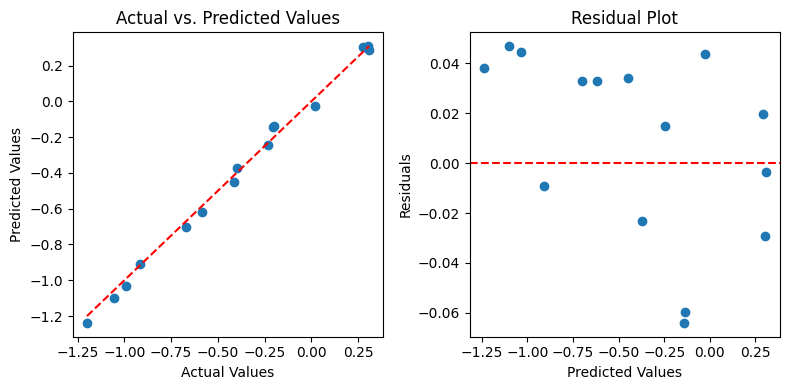

In [7]:
# First model
first_model = perform_linear_regression(X_a, y)


Mean Squared Error (MSE): 1.7219e-03
Mean Absolute Error (MAE): 3.4702e-02
R-squared (R²) Score: 9.9267e-01
Coefficients:
1.0619205228938946
17.178157345791817


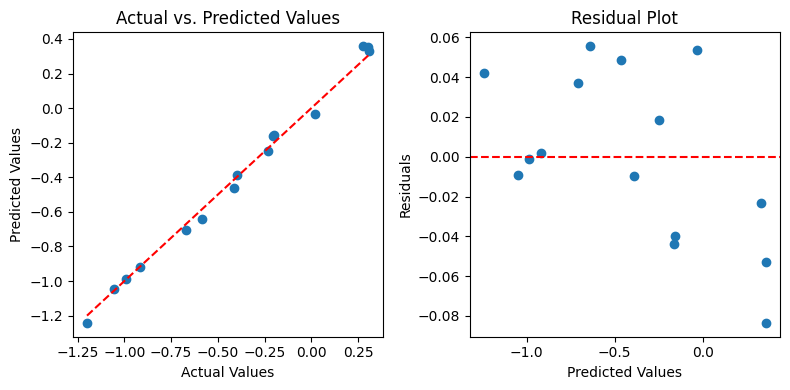

In [8]:
# Second model
second_model = perform_linear_regression(X_b, y)

In [9]:
# Save both models in a pickle file
def save_model(model, model_name):
    model_file_path = os.path.join(saved_models_path, f'relative_model_two_cars/{model_name}.pkl')
    
    with open(model_file_path, 'wb') as file:
        pickle.dump(model, file)
    
    print(f'Model "{model_name}" saved to: {model_file_path}')

save_model(first_model, 'first_model')
save_model(second_model, 'second_model')



Model "first_model" saved to: /home/ali/tum/motion_planning/social_ai_practical_course/results/models/relative_model_two_cars/first_model.pkl
Model "second_model" saved to: /home/ali/tum/motion_planning/social_ai_practical_course/results/models/relative_model_two_cars/second_model.pkl
